In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['inceptionresnetv2-oversampling', 'humpback-whale-identification', 'whales-cropped', 'oversampling']


In [2]:
HW = 'humpback-whale-identification'
# TRAIN = '../input/humpback-whale-identification/train/'
TRAIN_CROPPED = "whales-cropped/cropped_train/cropped_train/"
TRAIN_CROPPED_IN = '../input/' + TRAIN_CROPPED

# TEST = '../input/humpback-whale-identification/test/'
TEST_CROPPED = "whales-cropped/cropped_test/cropped_test/"
TEST_CROPPED_IN = '../input/' + TEST_CROPPED

LABELS = '../input/humpback-whale-identification/train.csv'
LABELS_OVERSAMPLED = '../input/oversampling/oversampled_train_and_val_shuffled.csv'

SAMPLE_SUB = '../input/humpback-whale-identification/sample_submission.csv'

train = pd.read_csv(LABELS)
print("With new_whale:")
train.head()

With new_whale:


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
MODEL_F = 'Model_InceptionResNetV2_flow.h5'
WEIGHTS_F = 'Weights_InceptionResNetV2_flow.h5'
MODEL = '../input/inceptionresnetv2-oversampling/'+ MODEL_F
WEIGHTS = '../input/inceptionresnetv2-oversampling/'+ WEIGHTS_F

In [4]:
train.describe()

,Image,Id
count,25361,25361
unique,25361,5005
top,8c16710af.jpg,new_whale
freq,1,9664


Example whale image
1683955c4.jpg


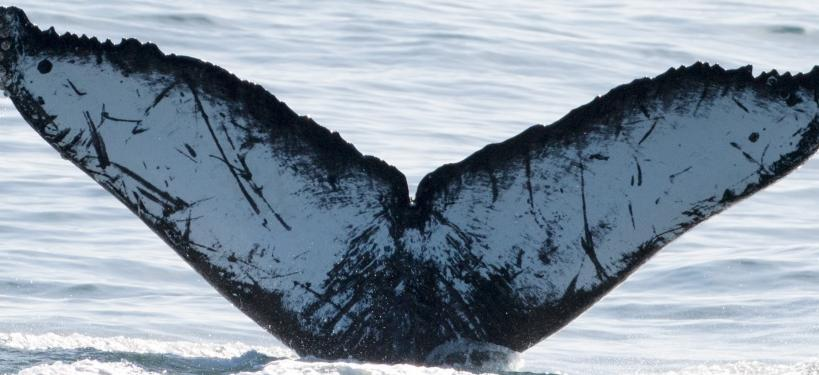

In [5]:
import random 
from IPython.display import Image
print("Example whale image")

#show sample image
name = random.choice(train['Image'])
print(name)
Image(filename = TRAIN_CROPPED_IN + name)

In [6]:
whales_train = pd.read_csv(LABELS_OVERSAMPLED)
print("Without new_whale:")
whales_train.head()

Without new_whale:


,Image,Id
0,74cd18adc.jpg,w_b3e445e
1,dbeb7e38a.jpg,w_8157927
2,49cf95c56.jpg,w_3c58b68
3,8a05a853c.jpg,w_180e241
4,471e75940.jpg,w_700ebb4


In [7]:
unique_labels = np.unique(whales_train.Id.values)
labels_list = unique_labels
print("Labels list:")
print(np.shape(labels_list))
print(labels_list[:20])

Labels list:
(5004,)
['w_0003639' 'w_0003c59' 'w_0027efa' 'w_00289b1' 'w_002c810' 'w_0032a46'
 'w_003bae6' 'w_00656c0' 'w_0066399' 'w_007fefa' 'w_00904a7' 'w_009c9c5'
 'w_00a41ba' 'w_00b3dc2' 'w_00d50c9' 'w_00d5466' 'w_00d5e98' 'w_00f340d'
 'w_010f858' 'w_0115c24']


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# from keras.applications.imagenet_utils import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

from keras.losses import binary_crossentropy

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.metrics import top_k_categorical_accuracy

import keras.backend as K
from keras.models import Sequential
from PIL import Image
import gc
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

%matplotlib inline

Using TensorFlow backend.


In [9]:
import keras.backend as K
from keras.callbacks import Callback

class GcCollectors(Callback):
    def __init__(self):
        super().__init__()
        
    def on_epoch_end(self, ep, logs=None):
        gc.collect()
        
    def on_epoch_begin(self, ep, logs=None):
        gc.collect()
     
    def on_train_begin(self, logs=None):
        gc.collect()

    def on_train_end(self, logs=None):
        gc.collect()

In [10]:
gc_collector = GcCollectors()

In [11]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

CLASSES = 5004
EPOCHS = 20
BATCH_SIZE = 32

IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
# setup model
# base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = IMAGE_SHAPE)

# x = base_model.output
# x = GlobalAveragePooling2D(name='avg_pool')(x)
# x = Dropout(0.4)(x)
# predictions = Dense(CLASSES, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)
   
# # transfer learning
# layers_len = len(model.layers)

# # I've chosen to train all the layers
# for layer in model.layers:
#    layer.trainable = True
      
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy', top_5_accuracy])

# model.summary()

In [12]:
gc.collect()

4

# Load model from disc <a name="flow"></a>
____

In [13]:
from keras.models import load_model

# returns a compiled model
# identical to the previous cell
model = load_model(MODEL, custom_objects={'top_5_accuracy': top_5_accuracy})
print("Loaded model architecture from disk")

model.load_weights(WEIGHTS)
print("Loaded model weights from disk")
model.summary()

gc.collect()

Loaded model architecture from disk
Loaded model weights from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________

5

# Train more on augmented data <a name="flow"></a>
____

In [14]:
from keras.callbacks import LambdaCallback, ModelCheckpoint
# from keras.applications.imagenet_utils import preprocess_input

ROTATE = 20
SEED = 42
gc.collect()

batch_gc_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: gc.collect())

checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    fill_mode='nearest',
    validation_split = 0.1,
    rotation_range=ROTATE,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=whales_train, 
    subset = "training",
    directory=TRAIN_CROPPED_IN, 
    x_col="Image", 
    y_col="Id", 
    has_ext=True, 
    seed = SEED,
    color_mode= "rgb",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size=BATCH_SIZE, 
    class_mode='categorical')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=whales_train, 
    subset = "validation",
    directory=TRAIN_CROPPED_IN, 
    x_col="Image", 
    y_col="Id", 
    has_ext=True, 
    seed = SEED,
    color_mode= "rgb",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size=BATCH_SIZE, 
    class_mode='categorical')

gc.collect()

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image.py:2059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[x_col] = self.df[x_col].astype(str)


Found 14155 images belonging to 5004 classes.
Found 1542 images belonging to 5004 classes.


56

# Visualize augmented data <a name="flow"></a>
____

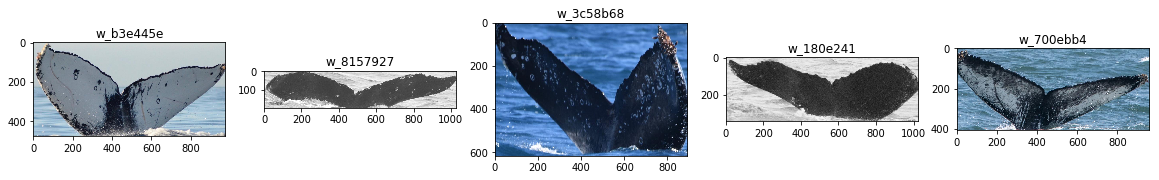

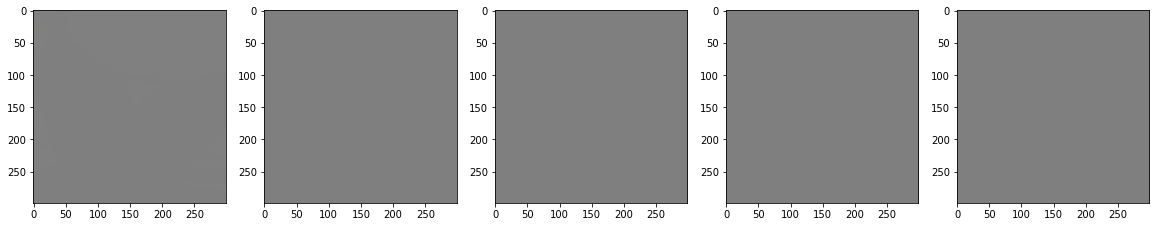

In [15]:
from skimage.io import imread
import PIL.Image as pimage

def plot_images(images_names, path):
    fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))
    #show the images and label them
    for ii, c_ax in enumerate(m_axs):
        img = imread(os.path.join(path,images_names[ii][0]))
        c_ax.imshow(img)
        c_ax.set_title(images_names[ii][1])

def plot_loaded_images(images_loaded, labels):
    fig, m_axs = plt.subplots(1, len(images_loaded), figsize = (20, 10))
    #show the images and label them
    for ii, c_ax in enumerate(m_axs):
        img = pimage.fromarray(images_loaded[ii], "RGB")
        c_ax.imshow((images_loaded[ii] + 1) / 2)
#         c_ax.set_title(labels[ii])
        
#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(whales_train.Image[:5], whales_train.Id[:5])]
plot_images(images, TRAIN_CROPPED_IN)

x_batch, y_batch = next(validation_generator)
plot_loaded_images(x_batch[:5], y_batch[:5])

In [16]:
# fits the model on batches with real-time data augmentation:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

# Train the loaded model 
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                             callbacks = [gc_collector])

Epoch 1/20
442/442 [==============================] - 1306s 3s/step - loss: 1.4819 - acc: 0.6277 - top_5_accuracy: 0.8595 - val_loss: 7.4103 - val_acc: 0.2135 - val_top_5_accuracy: 0.3464
Epoch 2/20
442/442 [==============================] - 1251s 3s/step - loss: 1.2330 - acc: 0.6865 - top_5_accuracy: 0.8950 - val_loss: 7.0033 - val_acc: 0.2570 - val_top_5_accuracy: 0.3927
Epoch 3/20
442/442 [==============================] - 1258s 3s/step - loss: 1.0408 - acc: 0.7259 - top_5_accuracy: 0.9227 - val_loss: 6.2988 - val_acc: 0.3404 - val_top_5_accuracy: 0.4689
Epoch 4/20
442/442 [==============================] - 1260s 3s/step - loss: 0.8465 - acc: 0.7792 - top_5_accuracy: 0.9455 - val_loss: 6.3653 - val_acc: 0.3437 - val_top_5_accuracy: 0.4768
Epoch 5/20
442/442 [==============================] - 1260s 3s/step - loss: 0.6813 - acc: 0.8189 - top_5_accuracy: 0.9626 - val_loss: 6.5453 - val_acc: 0.3126 - val_top_5_accuracy: 0.4563
Epoch 6/20
442/442 [==============================] - 1267s 

# Plot train results <a name="flow"></a>
____

In [17]:
def plot_accuracy(history, should_plot_val = False):
    acc = history.history['acc']
    l1 = plt.plot(acc, label='acc')
    
    if should_plot_val:
        val_acc = history.history['val_acc']
        l2 = plt.plot(val_acc, label='val_acc')
        
    plt.legend(loc=2, fontsize="small")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
def plot_loss(history, should_plot_val = False):
    loss = history.history['loss']
    l1 = plt.plot(loss, label='loss')
    
    if should_plot_val:
        val_loss = history.history['val_loss']
        plt.plot(val_loss, label='val_loss')
        
    plt.legend(loc=2, fontsize="small")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

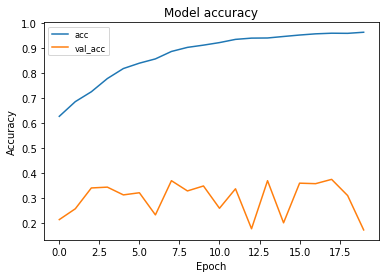

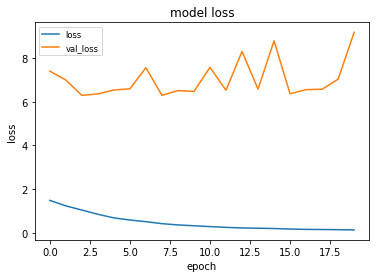

In [18]:
plot_accuracy(history, True)
plot_loss(history, True)

In [19]:
model.save(MODEL_F)
print("Saved model architecture to disk")
model.save_weights(WEIGHTS_F)
print("Saved model weights to disk")

Saved model architecture to disk
Saved model weights to disk


In [20]:
test = os.listdir(TEST_CROPPED_IN)
print("Test set length: "+str(len(test)))

Test set length: 7960


In [21]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

# Test set prediction using generator and flow_from_dataframe <a name="flow"></a>
____

In [22]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    fill_mode='nearest')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory=TEST_CROPPED_IN, 
    x_col="Image", 
    y_col=None,
    class_mode=None,
    shuffle=False,
    color_mode= "rgb",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size=1)

#we need to use .reset() here otherwise
#the other of predictions will be different
#then the expected
test_generator.reset()
predictions = model.predict_generator(test_generator,verbose = 1,steps=7960)

print("Predictions shape:")
print(np.shape(predictions))

Found 7960 images.
7960/7960 [==============================] - 664s 83ms/step
Predictions shape:
(7960, 5004)


# Test set predictions <a name="flow"></a>
____

In [23]:
predicted_class_indices=np.argmax(predictions,axis=1)

np.save("predictions.npy", predictions)
np.save("predicted_class_indices.npy", predicted_class_indices)
np.save('test_filenames_generator.npy', test_generator.filenames)
np.save('train_class_indices.npy', train_generator.class_indices)

print('predicted class indices:')
print(predicted_class_indices)

# print('Indices mapping:')
# print(train_generator.class_indices)

predicted class indices:
[3333 1211 3745 ... 4686 2687  343]


In [24]:
print(labels_list[:7])
labels_with_new_whale = np.concatenate((['new_whale'], labels_list), axis=0)    
print(labels_with_new_whale[:7])

['w_0003639' 'w_0003c59' 'w_0027efa' 'w_00289b1' 'w_002c810' 'w_0032a46'
 'w_003bae6']
['new_whale' 'w_0003639' 'w_0003c59' 'w_0027efa' 'w_00289b1' 'w_002c810'
 'w_0032a46']


In [25]:
def add_new_whale_to_predictions(preds):
    sorted_preds = np.sort(preds)
    avg_of_max_predictions = np.average(sorted_preds[:, -1:])
    print("Average of max probabilities column:" + str(avg_of_max_predictions))
    best_threshold = avg_of_max_predictions
    # print(np.shape(preds))
    shape_to_add = (np.shape(preds)[0], 1)
    
    # Add a column with the best threshold probability to the predictions
    column_to_add = np.zeros(shape_to_add) + best_threshold
    predictions_w_new_whale = np.concatenate([column_to_add, preds], axis=1)
    return predictions_w_new_whale

In [26]:
classes = dict((v,k) for k,v in train_generator.class_indices.items())

def get_generator_class(index):
    if index == 0:
        return 'new_whale'
    return classes[index-1]

def create_results_csv(preds, labels_with_new_whale, test_file_names, output_filename):
    sample_df = pd.read_csv(SAMPLE_SUB)
    sample_images = list(sample_df.Image)

    print("Test file names for decoding:")
    print(test_file_names[:7])
    
#     classes = dict((v,k) for k,v in train_generator.class_indices.items())
#     print("Generator classes:")
#     print(classes)
    
    pred_list = [[get_generator_class(i) for i in p.argsort()[-5:][::-1]] for p in preds]
    print(pred_list[:10])
    
    pred_dic = dict((key, value) for (key, value) in zip(test_file_names, pred_list))
    pred_list_for_test = [' '.join(pred_dic[id]) for id in sample_images]

#     print(np.shape(pred_list))
#     print(np.shape(test_file_names))
    df = pd.DataFrame({'Image': sample_images, 'Id': pred_list_for_test})
    df.to_csv(output_filename, header=True, index=False)
    return df

In [27]:
p = add_new_whale_to_predictions(predictions)
test_df = create_results_csv(p, labels_with_new_whale, test_generator.filenames, "submission.csv")
print(test_df[:10])

Average of max probabilities column:0.65336853
Test file names for decoding:
['00028a005.jpg', '000dcf7d8.jpg', '000e7c7df.jpg', '0019c34f4.jpg', '001a4d292.jpg', '00247bc36.jpg', '0027089a4.jpg']
[['new_whale', 'w_a1a4bb2', 'w_11d8c70', 'w_8d9af77', 'w_f7cd240'], ['w_6e7763b', 'new_whale', 'w_e3956f5', 'w_2b17316', 'w_0e93f25'], ['w_6658081', 'new_whale', 'w_cd4cb49', 'w_591a2c5', 'w_5a7e338'], ['new_whale', 'w_bc7de9f', 'w_fec331a', 'w_f66ec54', 'w_27597ff'], ['new_whale', 'w_e2372d6', 'w_06619ff', 'w_502e72f', 'w_b60ef24'], ['new_whale', 'w_0e7ec27', 'w_9b5109b', 'w_059d9e0', 'w_71a1a08'], ['new_whale', 'w_9d6c63d', 'w_7e2eb3d', 'w_65f142a', 'w_be36790'], ['w_b5cf062', 'new_whale', 'w_591a2c5', 'w_e2372d6', 'w_06619ff'], ['w_c6d75ff', 'new_whale', 'w_9490369', 'w_591a2c5', 'w_1f41b98'], ['w_d3baa35', 'new_whale', 'w_b60ef24', 'w_7a083f7', 'w_01ed442']]
           Image                                                 Id
0  00028a005.jpg  new_whale w_a1a4bb2 w_11d8c70 w_8d9af77 w_f7cd